In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# !pip install tensorflow-gpu==2.3.0
# !pip install sklearn

In [3]:
import tensorflow
import tensorflow as tf

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16503307398752191630,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8052953285104884725
 physical_device_desc: "device: XLA_CPU device"]

In [7]:
# part = 'right_arm'
# part = 'left_arm'
# part = 'right_leg' 
part = 'left_leg'

actions = ['assult', 'normal']

file_dir = 'C:/Users/BVer/are_you_ok/dataset/' + part + '/'#part 폴더를 dataset 폴더에 넣어주세요

npy_file = []
for name in os.listdir(file_dir):
    if not len(np.load(file_dir + name)) == 0:
        npy_file.append(np.load(file_dir + name))

data = np.concatenate(npy_file, axis=0)

data.shape

(50251, 30, 3)

In [8]:
if part == 'right_arm':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [1, 2, 4, 6]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
elif part == 'left_arm':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [0, 2, 3, 5]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
elif part == 'right_leg':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [8, 10, 12]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
elif part == 'left_leg':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [7, 9, 11]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1

In [9]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(50251, 30, 2)
(50251,)


In [10]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(50251, 2)

In [11]:
y_data[0]

array([0., 1.], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(45225, 30, 2) (45225, 2)
(5026, 30, 2) (5026, 2)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17152     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 19,298
Trainable params: 19,298
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/' + part + '_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
1412/1414 [============================>.] - ETA: 0s - loss: 1.3420 - acc: 0.9683
Epoch 00001: val_acc improved from -inf to 0.96439, saving model to models\left_leg_model.h5
1414/1414 [==============================] - 10s 7ms/step - loss: 1.3416 - acc: 0.9683 - val_loss: 0.3088 - val_acc: 0.9644
Epoch 2/200
1406/1414 [============================>.] - ETA: 0s - loss: 38.6526 - acc: 0.9683
Epoch 00002: val_acc improved from 0.96439 to 0.97214, saving model to models\left_leg_model.h5
1414/1414 [==============================] - 9s 6ms/step - loss: 38.4548 - acc: 0.9683 - val_loss: 0.2430 - val_acc: 0.9721
Epoch 3/200
1411/1414 [============================>.] - ETA: 0s - loss: 1.9866 - acc: 0.9724
Epoch 00003: val_acc improved from 0.97214 to 0.97791, saving model to models\left_leg_model.h5
1414/1414 [==============================] - 9s 6ms/step - loss: 1.9834 - acc: 0.9724 - val_loss: 0.6941 - val_acc: 0.9779
Epoch 4/200
1414/1414 [==============================] - ETA:

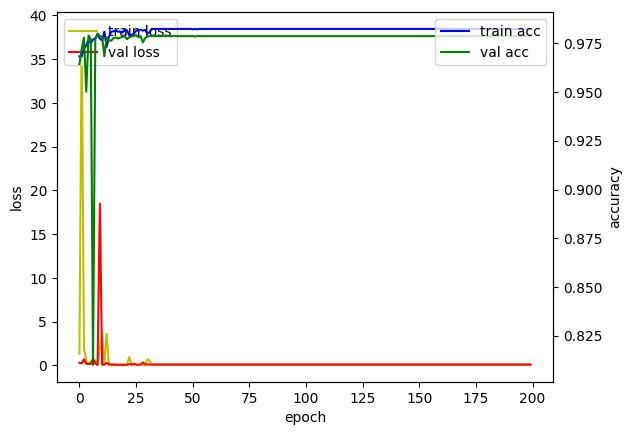

In [15]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [16]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('./models/' + part + '_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[4901,   18],
        [  82,   25]],

       [[  25,   82],
        [  18, 4901]]], dtype=int64)

In [17]:
file_dir1 = 'C:/Users/BVer/are_you_ok/preprocessing'

In [58]:
raw_data = np.load(file_dir1 + '/kicking/' + 'raw_kicking_kicking_k24.mp4.npy')

In [63]:
raw_data = np.load(file_dir1 + '/kicking/' + 'raw_kicking_kicking_k64.mp4.npy')

In [51]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_0_slaping_k34.mp4_0_.npy')

In [56]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_0_slaping_k29.mp4_0_.npy')

In [28]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_normal_normal1.mp4.npy')

In [64]:
raw_data.shape

(71, 67)

In [65]:
def pred_raw_part(test):
    test = test[:, 54:-1]
    seq_length = 30

    actions = ['assult', 'normal']
    
    right_arm_seq = [] #2,3
    left_arm_seq = [] #4,5
    right_leg_seq = [] #7,8
    left_leg_seq = [] #10,11

    right_arm_action = 0
    left_arm_action = 0
    right_leg_action = 0      
    left_leg_action = 0

    nan_skip_count = 10 #오차 허용 프레임
    
    right_arm_nan = 0
    left_arm_nan = 0
    right_leg_nan = 0      
    left_leg_nan = 0
        
    for index, angle_data in enumerate(test):
        right_arm_nan = take_not_nan(angle_data[2], angle_data[3], right_arm_seq, right_arm_nan)
        left_arm_nan = take_not_nan(angle_data[4], angle_data[5], left_arm_seq, left_arm_nan)
        right_leg_nan = take_not_nan(angle_data[7], angle_data[8], right_leg_seq, right_leg_nan)
        left_leg_nan = take_not_nan(angle_data[10], angle_data[11], left_leg_seq, left_leg_nan)
        
        if right_arm_nan == 15:
            right_arm_seq = []
            right_arm_action = 0
        if left_arm_nan == 15:
            left_arm_seq = []
            left_arm_action = 0
        if right_leg_nan == 15:
            right_leg_seq = []
            right_leg_action = 0
        if left_leg_nan == 15:
            left_leg_seq = []
            left_leg_action = 0
        
        
#         right_arm_action = pred_part(right_arm_seq, right_arm_nan, right_arm_model, right_arm_action, 'right_arm')
#         left_arm_action = pred_part(left_arm_seq, left_arm_nan, left_arm_model, left_arm_action, 'left_arm')
#         right_leg_action = pred_part(right_leg_seq, right_leg_nan, right_leg_model, right_leg_action, 'right_leg')
        left_leg_action = pred_part(left_leg_seq, left_leg_nan, model, left_leg_action, 'left_leg')

In [70]:
def take_not_nan(key1, key2, part_seq, part_nan):
    if not np.isnan(key1) and not np.isnan(key2):
        part_seq.append([key1, key2])
        return 0
    else:
        part_nan += 1
        if part_nan > 10: #오차 허용 프레임
            return 15
        else:
            return part_nan
        
def pred_part(part_seq, part_nan, part_model, part_action, part_name):
    seq_length = 30
    if len(part_seq) > seq_length and part_nan == 0:
        input_data = np.expand_dims(np.array(part_seq[-seq_length:], dtype=np.float32), axis=0)
        y_pred = part_model.predict(input_data).squeeze()

        i_pred = int(np.argmax(y_pred))
        conf = y_pred[i_pred]
        
#         print(conf, i_pred)

        if conf > 0.5 and i_pred == 0: #신뢰도
            part_action += 1
#             print(part_action)
            if part_action > 3:
                print(part_name, '  detect  assult ')
            return part_action
        else:
            return 0
    return part_action

In [71]:
pred_raw_part(raw_data)

left_leg   detect  assult 
left_leg   detect  assult 
left_leg   detect  assult 
left_leg   detect  assult 
left_leg   detect  assult 
left_leg   detect  assult 
